In [1]:
import os

In [3]:
os.listdir('./archive/Training')

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output

In [ ]:
!pip install tensorflow

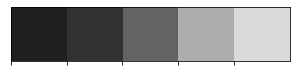

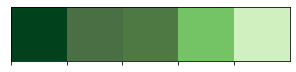

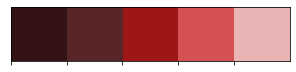

In [8]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [9]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [10]:
from numpy import expand_dims
#from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot


X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('./archive','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        
       #selecting only no tumor images sorting by labels 
        if i=='no_tumor':
            data = img_to_array(img)
            #expand ranks of the images
            samples = expand_dims(data, 0)
            
            # create image data augmentation generator
            
            datagen = ImageDataGenerator(rotation_range=90 , horizontal_flip=True)
            
            
            # prepare iterator
            
            it = datagen.flow(samples, batch_size=1)
            
           #generate samples and plot
            for k in range(2):
                
                # define subplot
                #pyplot.subplot(330 + 1 + i)
                
                
                # generate batch of images
                batch = it.next()
               
                
                # convert to unsigned integers for viewing
                image = batch[0].astype('uint8')
                
                #pyplot.imshow(image)
                
            # show the figure
            #pyplot.show()
                
                X_train.append(image)
                y_train.append(i)
        else:
            X_train.append(img)
            y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('./archive','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
#print X_train length to check if the array length increase by 395
print(len(X_train))
y_train = np.array(y_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 85.20it/s]

3659


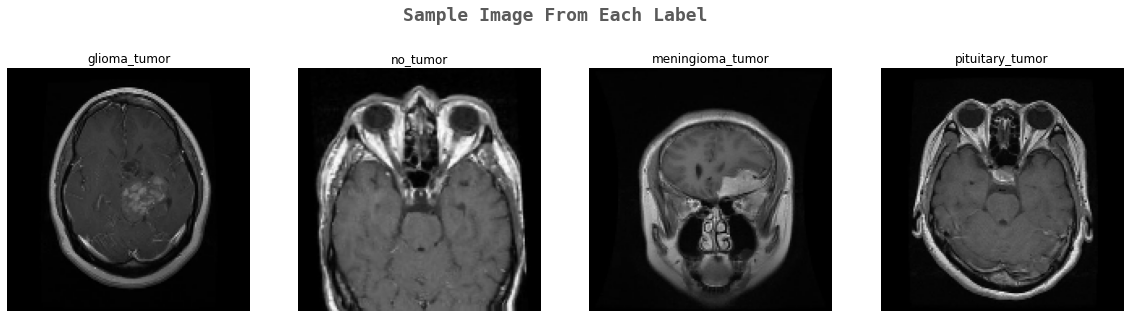

In [11]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [12]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [13]:
X_train.shape

(3659, 150, 150, 3)

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [15]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [17]:
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import preprocess_input,VGG16

In [34]:
vggmod = VGG16(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [35]:
model = vggmod.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=vggmod.input, outputs = model)

In [36]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [37]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("vgg.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [38]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
93/93 [==============================] - ETA: 0s - loss: 2.4349 - accuracy: 0.2582
Epoch 1: val_accuracy improved from -inf to 0.27879, saving model to vgg.h5
93/93 [==============================] - 577s 6s/step - loss: 2.4349 - accuracy: 0.2582 - val_loss: 1.3709 - val_accuracy: 0.2788 - lr: 0.0010
Epoch 2/20
93/93 [==============================] - ETA: 0s - loss: 1.3685 - accuracy: 0.2828
Epoch 2: val_accuracy did not improve from 0.27879
93/93 [==============================] - 580s 6s/step - loss: 1.3685 - accuracy: 0.2828 - val_loss: 1.3688 - val_accuracy: 0.2758 - lr: 0.0010
Epoch 3/20
93/93 [==============================] - ETA: 0s - loss: 1.2669 - accuracy: 0.3547
Epoch 3: val_accuracy improved from 0.27879 to 0.47576, saving model to vgg.h5
93/93 [==============================] - 582s 6s/step - loss: 1.2669 - accuracy: 0.3547 - val_loss: 1.1356 - val_accuracy: 0.4758 - lr: 0.0010
Epoch 4/20
93/93 [==============================] - ETA: 0s - loss: 1.2792 - accura

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [41]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)


In [42]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.61      0.66      0.63       102
           1       0.79      0.96      0.87        85
           2       0.49      0.21      0.29        87
           3       0.72      0.90      0.80        92

    accuracy                           0.68       366
   macro avg       0.65      0.68      0.65       366
weighted avg       0.65      0.68      0.65       366



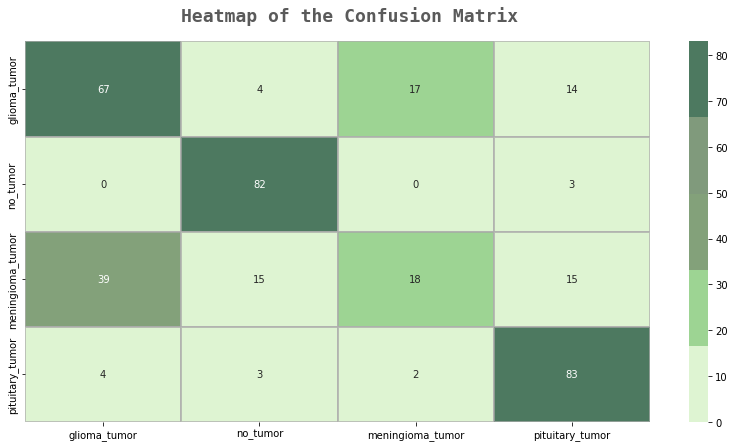

In [43]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()